# 1. Bootstrapping annotations

Annotating is hard work. In general, we have to take the following steps:

1.   Gather a corpus and create annotation guidelines
2.   Train a team of annotators or crowdsource annotations
3.   Make sure our annotations are of high quality by calculating the [Inter-Annotator Agreement](https://towardsdatascience.com/inter-annotator-agreement-2f46c6d37bf3).*

However, **we don't need to start from scratch**. We can decide to use off-the-shelf NER-tools to **bootstrap** annotations. In other words, we're making a first version of our annotated corpus which can then be post-corrected in our annotation platform of choice.

In this Notebook, we'll show you how to:


1.   Load an example corpus from our public GitHub page.
2.   Annotate this corpus with spaCy's off-the shelf model en_core_web_lg.
3.   Add the annotations to a **UIMA CAS XMI (XML 1.0.).**-file, which is the import file of our annotation platform.






---


❗ For our project at the Computational Literary Studies Project, we used a server instance of INCEPTION which allowed us to share projects - and used the library [Inceptalytics](https://github.com/catalpa-cl/inceptalytics) to get the results in the desired DataFrame format and calculate Inter-Annotator Agreement.

Check the section **More Information** for other open-source annotation platforms and other interesting sources!

## Required background knowledge 🧠

To run and adapt this Notebook, you need an intuitive understanding of the following topics and packages:


*   GitHub
*   spaCy
*   Annotation practices for NLP
*   Named Entity Recognition
*   XML



# 2. Load and install packages 📚

We load two packages:


1.   [spaCy](https://spacy.io/), an NLP-framework for Python which we will use to generate bootstrapped entities.
2.   [dkpro-cassis](https://github.com/dkpro/dkpro-cassis), a package which helps you to save annotations in a CAS-data structure.

We'll also download spaCy's off-the-shelf NER-model en_core_web_lg to create the annotations!



In [ ]:
%pip install spacy dkpro-cassis

!python -m spacy download en_core_web_lg

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.3/77.3 kB 679.1 kB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.2/52.2 kB 2.4 MB/s eta 0:00:00
  Created wheel for dkpro-cassis: filename=dkpro_cassis-0.9.1-py3-none-any.whl size=78088 sha256=eedf86fbc80f1ef319be9002612a182ae58c477fb48dd9eac802a0748430efd7
  Stored in directory: /root/.cache/pip/wheels/9b/4b/9e/6cea69983b5694b5b0f961dfa5d5bc096ed985b9f1c0540766
Successfully built dkpro-cassis
  Attempting uninstall: more-itertools
    Found existing installation: more-itertools 10.1.0
    Uninstalling more-itertools-10.1.0:
      Successfully uninstalled more-itertools-10.1.0
  Attempting uninstall: importlib_resources
    Found existing installation: importlib_resources 6.4.0
    Uninstalling importlib_resources-6.4.0:
      Successfully uninstalled importlib_resources-6.4.0
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 587.7/587.7 MB 2.6 MB/s eta 0:00:00
✔ Download and installa

In [ ]:
import glob
import pandas as pd

import spacy
from spacy import displacy
from cassis import *

# 3. Load our dataset 📜

In this code snippet we collect a multilingual corpus of travel literature from the GitHub repository pertaining to GhentCDH. You can find more information on this example corpus on our [GitHub repository](https://github.com/GhentCDH/CLSinfra).

 You'll see a folder named **CLSinfra**, which contains one subfolder **Example_data_CLS**. In this folder, you'll find the subfolders: **Dutch, English, French** and **German**. Each folder contains travel texts in these respective languages as text files.


We want to focus on the English texts for now!

In [ ]:
!git clone https://github.com/GhentCDH/CLSinfra.git

Cloning into 'CLSinfra'...
remote: Enumerating objects: 90, done.
remote: Counting objects: 100% (90/90), done.
remote: Compressing objects: 100% (87/87), done.
remote: Total 90 (delta 11), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (90/90), 11.11 MiB | 5.46 MiB/s, done.
Resolving deltas: 100% (11/11), done.


In [ ]:
folder_path = "/content/CLSinfra/Example_data_CLS/English"

In [ ]:
txt_paths = glob.glob(folder_path + "/**/**/*.txt", recursive=True) #find all txt files paths in subfolders

In [ ]:
travelogues = {}

for path in txt_paths:
    path_elements = path.split("/")
    file_name = path_elements[-1].strip(".txt")

    text = open(path, "r")
    travelogue_content = text.read()

    language = path_elements[-3]

    travelogues[file_name] = travelogue_content

In [ ]:
travelogues_df = pd.DataFrame.from_dict(travelogues, orient='index', columns = ["Travelogues"])
travelogues_df.reset_index(inplace=True, names = ["ID"])

Let's have a look at the texts we have gathered!

In [ ]:
travelogues_df

ID  \
0                          A_Wanderer_in_Venice   
1                        A_Wanderer_in_Florence   
2  Italian_Highways_and_Byways_from_a_Motor_Car   
3      Florence_and_Northern_Tuscany_with_Genoa   
4                     Cathedral_Cities_of_Italy   
5                                        Venice   
6                       Studies_of_Travel_Italy   
7                                          Rome   
8                     Roman_Holidays_and_Others   
9                              Vistas_in_Sicily   

                                         Travelogues  
0  Title: A Wanderer in Venice\nAuthor: E. V. Luc...  
1  Title: A Wanderer in Florence\nAuthor: E. V. L...  
2  Title: Italian Highways and Byways from a Moto...  
3  Title: Florence and Northern Tuscany with Geno...  
4  Title: Cathedral Cities of Italy\nAuthor: Will...  
5  Title: Venice \nAuthor: Dorothy Menpes \nPubli...  
6  Title: Studies of Travel: Italy\nAuthor: Edwar...  
7  Title: Rome\nAuthor: Mildred Anna Rosalie Tuke...  
8  Title: Roman Holidays and Others\nAuthor: W. D...  
9  Title: Vistas in Sicily \nAuthor: Arthur Stanl...

# 4. Annotate an example text

The open-source tool we will use to bootstrap our texts is **spaCy**. SpaCy has models that recognize a lot of other entities in [different languages](https://spacy.io/usage/models/).
Among others, SpaCy recognizes the following entities in **English**:

Entity | Description
-------------|------------
PERSON:      |People, including fictional.
NORP:        |Nationalities or religious or political groups.
FAC:         |Buildings, airports, highways, bridges, etc.
ORG:         |Companies, agencies, institutions, etc.
GPE:         |Countries, cities, states.
LOC:         |Non-GPE locations, mountain ranges, bodies of water.
PRODUCT:     |Objects, vehicles, foods, etc. (not services.)
EVENT:       |Named hurricanes, battles, wars, sports events, etc.
WORK_OF_ART: |Titles of books, songs, etc.
LAW:         |Named documents made into laws.
LANGUAGE:    |Any named language.
DATE:        |Absolute or relative dates or periods.
TIME:        |Times smaller than a day.
PERCENT:     |Percentage, including ”%“.
MONEY:       |Monetary values, including unit.
QUANTITY:    |Measurements, as of weight or distance.
ORDINAL:     |“first”, “second”, etc.
CARDINAL:    |Numerals that do not fall under another type.


Let's see what spaCy can do for us!



In [ ]:
nlp = spacy.load("en_core_web_lg")

In [ ]:
travelogue_ID, example_travelogue = next(iter(travelogues.items()))

In [ ]:
example_travelogue

'Title: A Wanderer in Venice\nAuthor: E. V. Lucas\nPublisher: THE MACMILLAN COMPANY\nPlace of publication: New York\nDate: 1914\n\nPREFACE\n\n\nFor a detailed guide to Venice the reader must go elsewhere; all that I\nhave done is invariably to mention those things that have most\ninterested me, and, in the hope of being a useful companion, often a few\nmore. But my chief wish (as always in this series) has been to create a\ntaste.\n\nFor the history of Venice the reader must also go elsewhere, yet for the\nsake of clarity a little history has found its way even into these\npages. To go to Venice without first knowing her story is a mistake, and\ndoubly foolish because the city has been peculiarly fortunate in her\nchroniclers and eulogists. Mr. H.F. Brown stands first among the living,\nas Ruskin among the dead; but Ruskin is for the student patient under\nchastisement, whereas Mr. Brown\'s serenely human pages are for all. Of\nMr. Howells\' Venetian Life I have spoken more than once i

In [ ]:
# Process the document
doc = nlp(example_travelogue)

# Render the Named Entities recognized by spaCy in a nice visualisation
displacy.render(doc, style="ent", jupyter=True)

# 5. Bootstrapping with spaCy

To import the annotations in our annotation platform INCEPTION, we need to transform the automatic annotations by spaCy into a data format the platform will understand. In this case, we're transforming the output of spaCy to **UIMA CAS XMI (XML 1.0.)**.

To do this, we have to load the typesystem file **typesystem_inception.xml** (the basic structure of the XML file, including the custom layers we created to annotate named entities) which will be used to structure our new annotations.
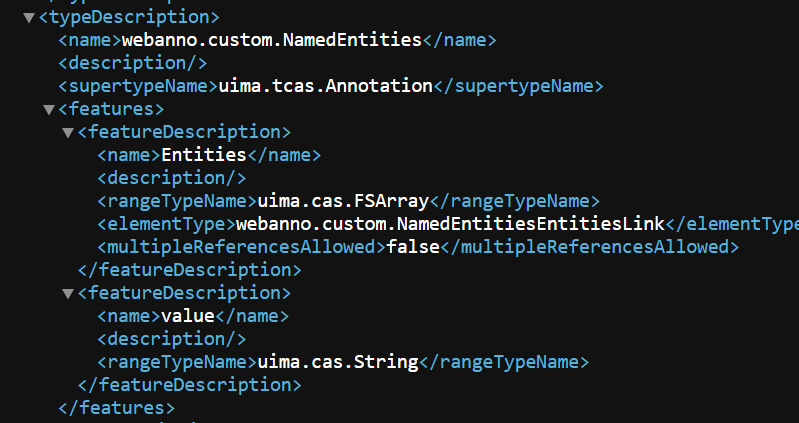
---


❗ If you use InCeption as your annotation platform - you can find this typesystem file if you download your project. **Have a look at the name spaces in your document. Those for the Sentence and Token elements are standardized, but if you created a custom layer which you want to populate, then you'll need the name space!**



In [ ]:
with open("/content/CLSinfra/Example_data_CLS/typesystem_inception.xml", "rb") as f:
  ts = load_typesystem(f)

In [ ]:
# Create the CAS
SENTENCE_TYPE = "de.tudarmstadt.ukp.dkpro.core.api.segmentation.type.Sentence"
TOKEN_TYPE = "de.tudarmstadt.ukp.dkpro.core.api.segmentation.type.Token"

# This is the Internal Name in the custom layer settings of Inception
NER_TYPE = "webanno.custom.NamedEntities"

First things first, we're not interested in all entity types!
We only want to add annotations for

Entity | Description
-------------|------------
PERSON:      |People, including fictional.
NORP:        |Nationalities or religious or political groups.
LOC:         |Buildings, airports, highways, bridges, etc.
ORG:         |Companies, agencies, institutions, etc.
GPE:         |Countries, cities, states.
FAUNA:         |Names of animals, including fictional. Both common names and scientific names.
FLORA:     |Names of plants, including fictional. Both common names and scientific names
WORK OF ART:     |Titles of books, songs, etc.


 **PERSON, ORG (organisation), LOC (location), WORK OF ART, and NORP (nationalities)**.

In [ ]:
entities = ["PERSON", "ORG", "LOC", "WORK_OF_ART", "NORP"]

This code takes the travelogues we have loaded as texts - and transforms them into annotated XML-files!

In [ ]:
#make a new directory called xmi_files to store the output of our bootstrapping operation
! mkdir xmi_files

In [ ]:
for name, text in travelogues.items():
    cas = Cas(typesystem=ts)
    cas.sofa_string = text

    #apply the annotation to the text by calling spaCy's NLP module on it.
    doc = nlp(text)

    # Each element in the XML-file has identifiers. We have to assert these first.
    Sentence = ts.get_type(SENTENCE_TYPE)
    Token = ts.get_type(TOKEN_TYPE)
    NamedEntity = ts.get_type(NER_TYPE)

    for sentence in doc.sents:
        cas_sentence = Sentence(begin=sentence.start_char, end=sentence.end_char)
        cas.add(cas_sentence)
        assert sentence.text == cas_sentence.get_covered_text()

    for token in doc:
        cas_token = Token(begin=token.idx, end=token.idx + len(token))
        cas.add(cas_token)
        assert token.text == cas_token.get_covered_text()

    for named_entity in doc.ents:
        if named_entity.label_ in entities:
          cas_named_entity = NamedEntity(begin=named_entity.start_char, end=named_entity.end_char, value = named_entity.label_)
          cas.add(cas_named_entity)
          assert named_entity.text == cas_named_entity.get_covered_text()
        else:
            continue

    #save the result to an XMI-file!
    xmi_path = f"/content/xmi_files/{name}.xmi"

    cas.to_xmi(xmi_path)

All of our resulting XMI-files can now be found in the folder **xmi_files**, and directly uploaded in **INCEPTION**!



❗ If you're interested you can play around with this data or use this for your own dataset. You can use different modelling approaches to create your bootstrapped files, within spaCy and beyond. Want to create a more elaborate or fine-tuned modelling approach? Check out the other Notebooks on our[ GitHub page](https://github.com/GhentCDH/CLSinfra/tree/main)!

# 6. Import to INCEPTION

You can download [INCEPTION](https://inception-project.github.io/), the open-source labelling platform, and start your own annotation project using the bootstrapped files you just created!


An example of a bootstrapped .xmi-file in INCEPTION is shown below.

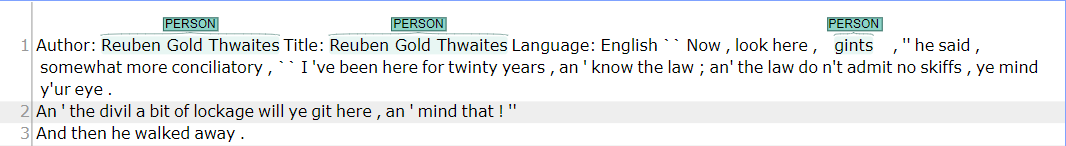

# 7. More information 🎓

## Food for thought 💭
❗ The **Inter-Annotator Agreement** basically calculates how well the annotations of different annotators overlap. It shows you how well your annotators understood the guidelines in a similar way. The Kappa scores (Fleiss' and Kappa) both incorporate the probability of a category in their calculations, and thus take into account that annotations may overlap due to chance.

While this is a perfectly sensible approach, the idea that we're measuring the quality of annotations according to how generalized the understanding of different categories is has come under scrutiny.

❓ In some cases, different annotations may be a reflection of a complex reality rather than a mistake. In a non-discrete world, and especially in a literary-historical context which infallibly falls victim to subjective interpretation - maybe we want our annotations to be as varied as possible?

## Interesting sources to check
If you're interested in the discussion surrounding labelling conventions and how it may affect your work, be sure to check out the paper by [Barbara Plank on human label variation](https://arxiv.org/abs/2211.02570)!


## Other open-source annotation platforms

Some examples of open-source annotation platforms to check out:


*   [INCEPTION](https://inception-project.github.io/)
*   [Doccano](https://github.com/doccano/doccano)
*   [FLAT](https://flat.readthedocs.io/en/latest/)
*   [Tecoholic](https://github.com/tecoholic/ner-annotator)
*   [Universal data tool](https://universaldatatool.com/)

These may of course come with other import and export formats.




## Annotation pipeline

Below you'll find a general visualization of the annotation pipeline for NLP-projects.

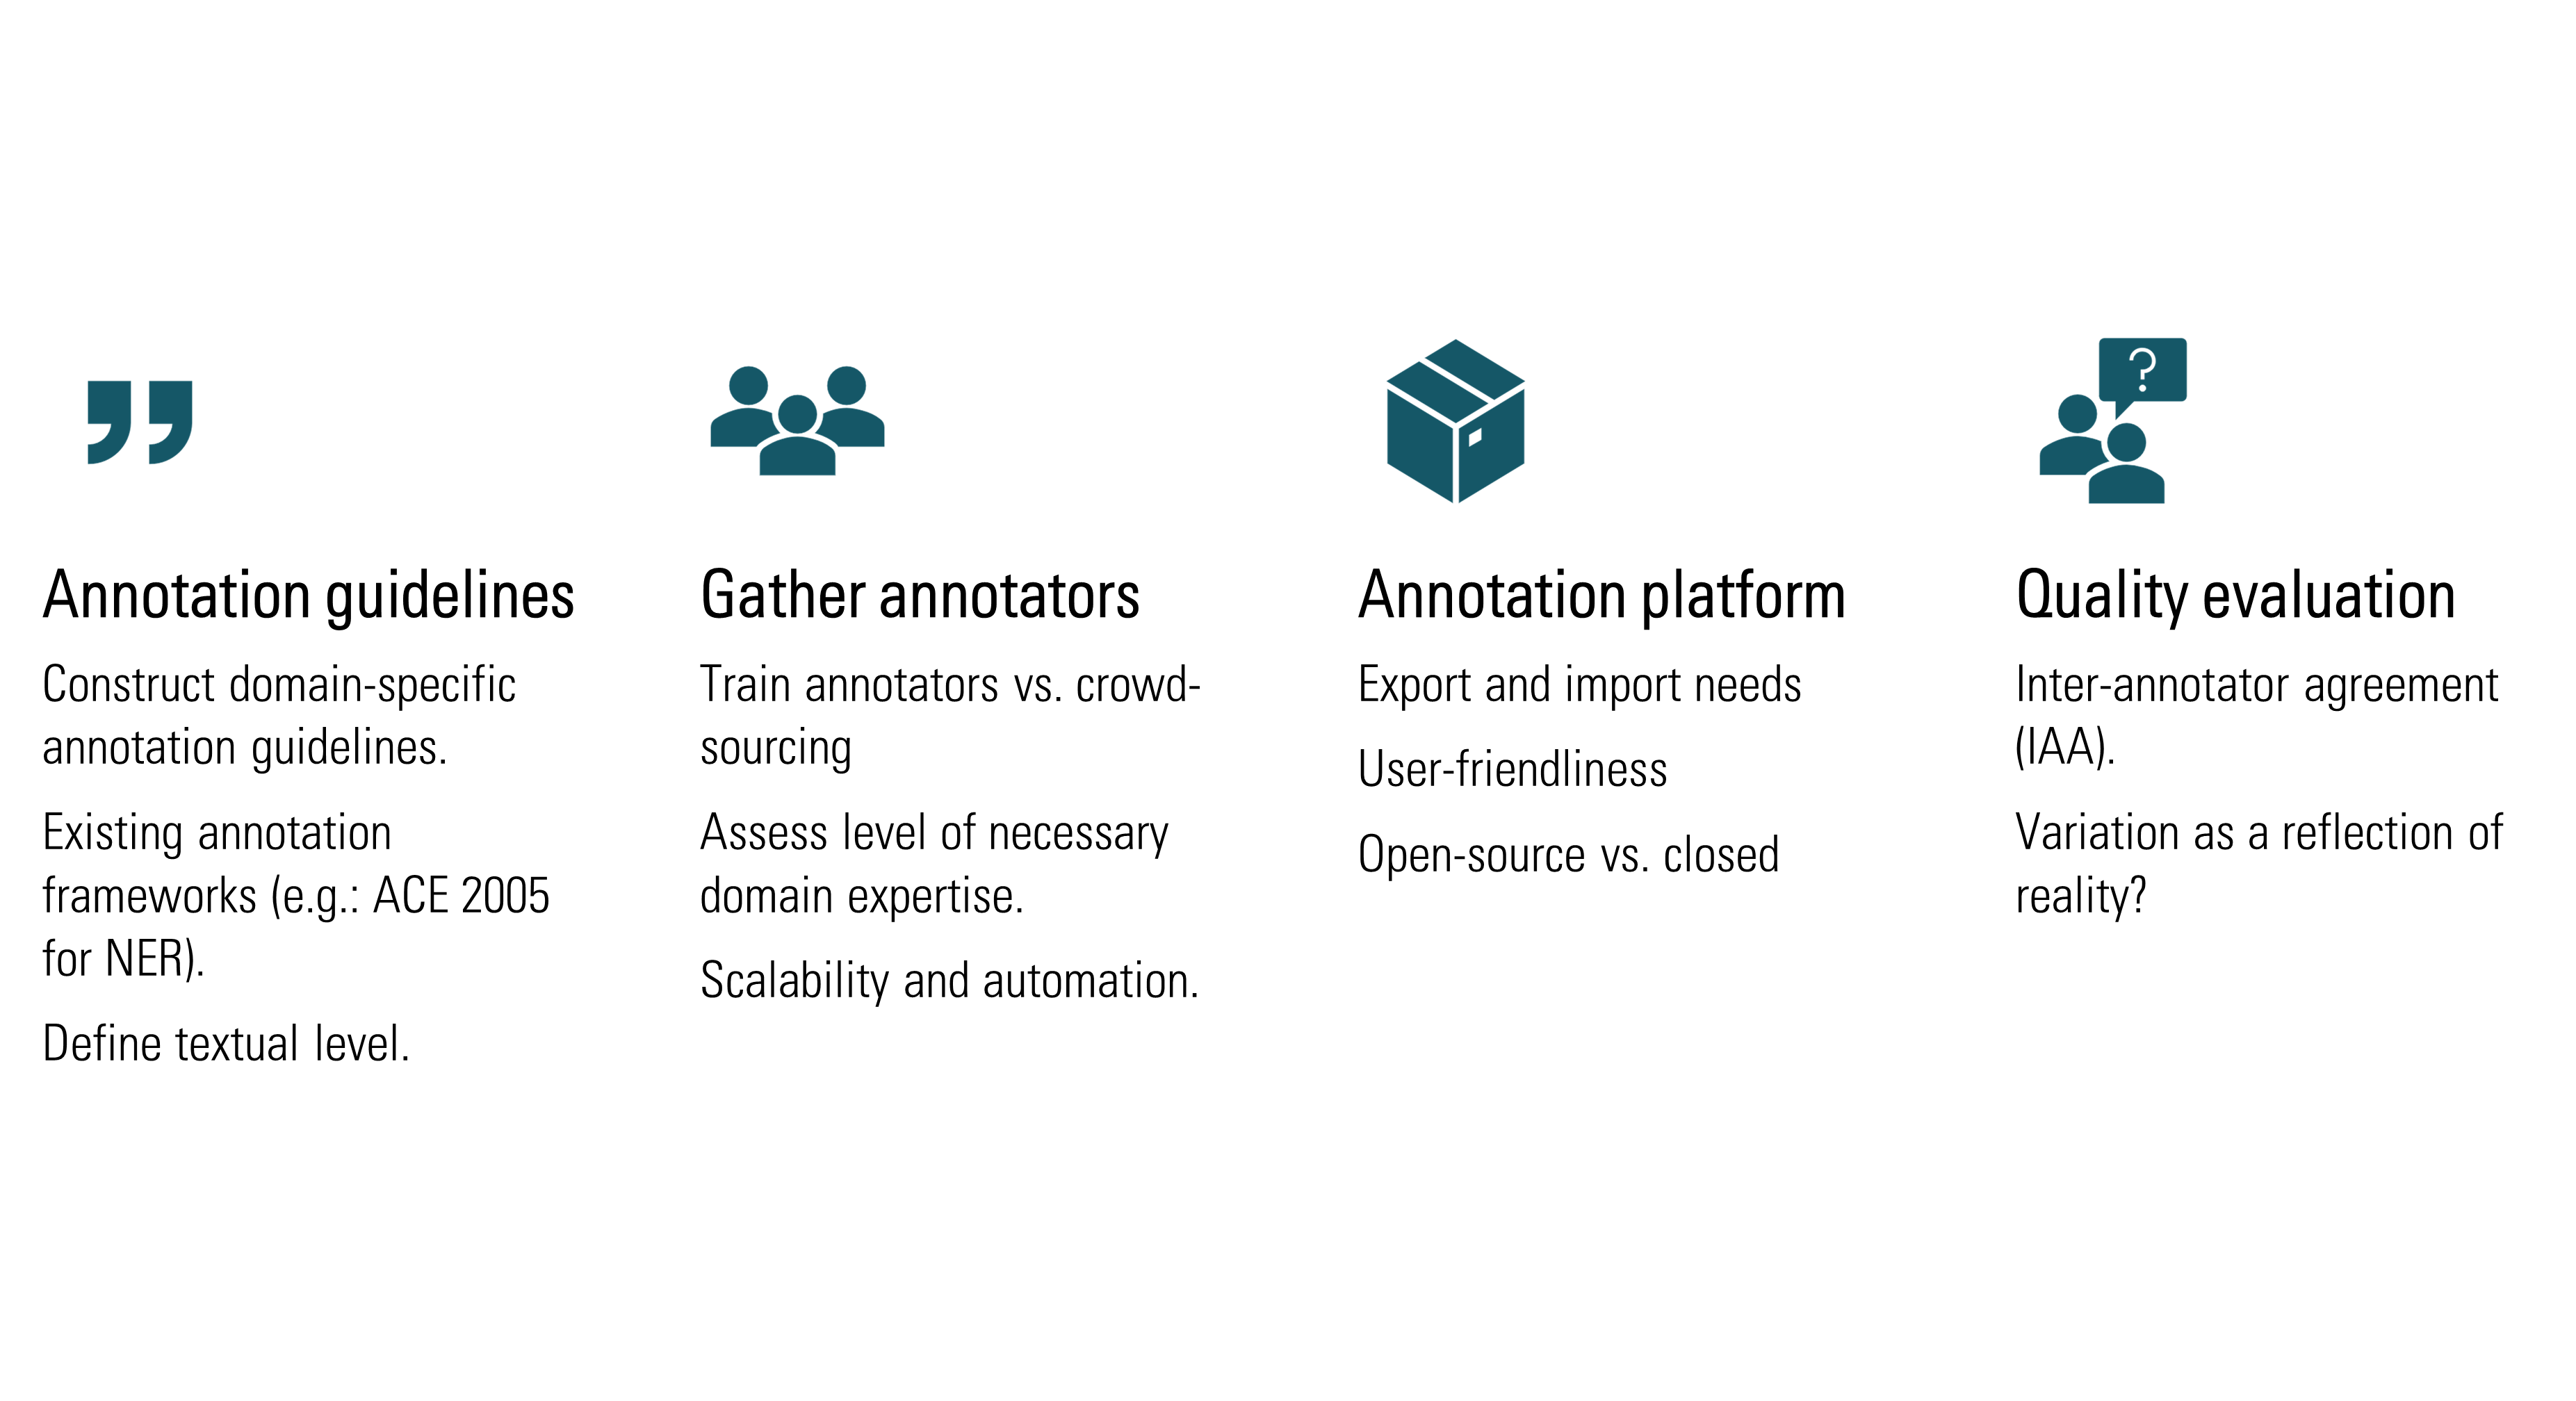